# Tareas

<div class="alert alert-warning">
Fecha límite de entrega: 9 de octubre, 2020 23:59
</div>

In [218]:
import sympy as sym
from sympy import *
from sympy import Symbol

In [219]:
import matplotlib.pyplot as plt
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D

In [220]:
from ipywidgets import interact, fixed, widgets

## Problema 1

**(a)** Usando **SimPy** demostrar que 

$$
\frac{\partial}{\partial \beta_j} \textbf{J}(\beta) = \frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}(x^{(i)}) - y(x^{(i)})\right) \cdot x^{(i)}_j
$$
Para el caso de $\beta_0, \beta_1$ en $J(\beta_0,\beta_1)$.

La función está dada por: 
$$\textbf{J}(\beta_0, \beta_1) = \frac{1}{2n}\sum_{(x^{(i)}, y^{(i)}) \in X \times Y} (y^{(i)} - \hat{y}^{(i)}(x^{(i)}))^2 = \frac{1}{2n}\sum_{(x^{(i)}, y^{(i)}) \in X \times Y} (y^{(i)} - \beta_0 - \beta_1 x^{(i)})^2$$
donde: 
$$
\hat{\textbf{y}} = \mathbf\beta_0 + \mathbf\beta_1 \textbf{x}
$$

In [302]:
#Añado todos los elementos a utilizar 
J = Function('J')
x = IndexedBase('x')
y = IndexedBase('y')
n, i = sym.symbols('n, i')
b0 = Symbol('beta_0')
b1 = Symbol('beta_1')

In [303]:
#Genero la función a derivar
func = (1/(2*n))*Sum((y[i]- b0 - (b1*x[i]))**2, (i, 1, n))
#Derivo con respecto a cada beta
d0 = simplify(diff(func, b0))
d1 = simplify(diff(func, b1))
#Doy formato de derivada
D0 = Eq(Derivative(J(b0), b0), d0)
D1 = Eq(Derivative(J(b1), b1), d1)

In [304]:
D0

Eq(Derivative(J(beta_0), beta_0), Sum(beta_0 + beta_1*x[i] - y[i], (i, 1, n))/n)

In [305]:
D1

Eq(Derivative(J(beta_1), beta_1), Sum((beta_0 + beta_1*x[i] - y[i])*x[i], (i, 1, n))/n)

## Problema 2

Usando el ejemplo de la clase ( i.e. Los archivos `edad.dat` y `altura.dat` contienen las mediciones de las estaturas (en metros) de varios niños entre las edad de 2 y 8 años. Cada _tupla_ de altura y edad, constituyen un ejemplo de entrenamiento $(x^{(i)}, y^{(i)})$ de nuestros datos. Hay $m = 50$ datos para entrenar que usaremos para realizar un modelo de regresión lineal. ) :

**(a)** Grafique $\textbf{J}(\beta)$ del ejercicio en $3D$ y en una gráfica de contorno.

In [13]:
#Genero la función J 
def J(b0, b1):
    X = np.loadtxt('edad.dat')
    Y = np.loadtxt('altura.dat')
    costo = 0
    for i in range (0, len(Y)): #Base indexada de la función J 
        costo += ((Y[i] - b0 - (b1*X[i]))**2)/(2*len(Y)) #evaluación de la función J para cada entero
    return costo

In [14]:
#Genero mis betas y las evalúo en la función J
b0 = np.arange(0, 1.5, 0.001)
b1 = np.arange(-1, 1, 0.001)
B0, B1 = np.meshgrid(b0, b1)
funJ = J(B0,B1)

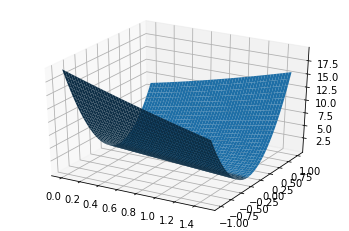

In [15]:
#Graficación de la función J
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection = '3d')
ax.plot_surface(B0,B1, funJ)

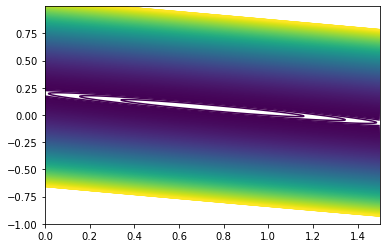

In [19]:
grafCont = plt.contour(B0, B1, funJ, levels = np.arange(0,10,0.01))
grafCont

**(b)** Indique con un punto el valor de $\textbf{J}(\beta)$ en la última iteración.

In [407]:
class RegresionLineal:
    def __init__(self, alpha=0.03, max_iters=100, tols=0.001):
        """
        Parámetros.
        ---------------
        alpha = Learning rate
        max_iters = Número máximo de iteraciones
        tols = definición de convergencia
        """
        self.alpha = alpha
        self.max_iters = max_iters
        self.tols = tols
        self.breaking_iteration = None
        self.historia = {'costo':[], 'beta':[]}  # Con fines de graficación
        
    def gradientDescent(self, x, y):
        """
        Parámetros:
        ---------------
        x = vector de entrenamiento de features
        y = vector de entrenamiento de variable a predecir (target)
        """    
        
        # ajustamos el vector de features
        unos = np.ones((x.shape[0], 1))
        Xt = x.reshape(x.shape[0], 1)
        Xt = np.concatenate((unos, Xt), axis=1)
        
        i = 0
        prep_J = 0
        m, n = Xt.shape
        self.beta = np.zeros(n) 
        
        while i < self.max_iters:     
            # Actualizamos beta
            self.beta = self.beta - self.alpha * self.gradiente(Xt, y)
            
            J = self.costo(Xt, y)
            
            if abs(J - prep_J) <= self.tols:
                print('La función convergió con beta: %s en la iteración %i' % ( str(self.beta), i ))
                self.breaking_iteration = i
                break
            else:
                prep_J = J
            
            self.historia['costo'].append(J)
            self.historia['beta'].append(self.beta)                
            i += 1
            
    def hipotesis(self, x):
        return np.dot(x, self.beta)
    
    def costo(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y
        return np.dot(error.T, error) / (2 * m) 
    
    def gradiente(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y        
        return np.dot(x.T, error) / m

In [408]:
def plotModelo(x,y,rl,iteracion, ejex, ejey):
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    
    _beta = rl.historia['beta'][iteracion]

    fig, ax = plt.subplots(1,2, figsize=(10,6))
    ax[0].scatter(x,y, label="datos")
    ax[0].plot(x, modelo(x, _beta[0], _beta[1]), label="int: %1.2f, pen: %1.2f" % (_beta[0], _beta[1]))
    ax[0].set_xlabel(ejex)
    ax[0].set_ylabel(ejey)
    ax[0].legend(loc="best")
    #ax[0].set_xlim(0, max(x))
    #ax[0].set_ylim(0, max(y))
    
    costo  = rl.historia['costo']
    
    iteraciones = [i for i in range(0, len(costo))]
    ax[1].plot(iteraciones, costo, 'g', label="costo")
    ax[1].plot(iteracion, costo[iteracion], 'or', label="iteracion")
    ax[1].set_xlabel('Iteraciones')
    ax[1].set_ylabel('Costo')
    ax[1].legend(loc="best")

In [411]:
X = np.loadtxt('edad.dat')
Y = np.loadtxt('altura.dat')

In [412]:
r = RegresionLineal(alpha=0.03, max_iters=10000, tols=0.0000001)
r.gradientDescent(X, Y)

La función convergió con beta: [0.73300235 0.06700325] en la iteración 1190


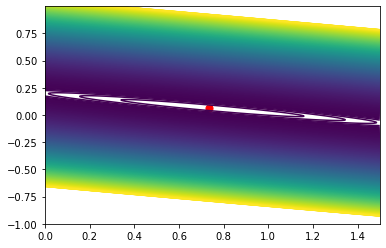

In [336]:
plt.contour(B0,B1, funJ, levels = np.arange(0,10,0.01))
plt.scatter(0.73300235,0.06700325,50, color = 'red')

**(c)** Modifique el _widget_ para mostrar conforme pasan las iteraciones como el valor de $\textbf{J}(\beta)$ se acerca al mínimo en la gráfica de contorno.

In [413]:
ultima_iteracion = (r.breaking_iteration - 1) if r.breaking_iteration else (r.max_iters - 1)

In [416]:
 def plotContorno(iteracion):
    _beta = r.historia['beta'][iteracion]
    fig = plt.figure()
    plt.contour(B0,B1,funJ, levels = np.arange(0,10,0.01))
    plt.scatter(_beta[0],_beta[1], 50, color = 'red') #Función para añadir el punto a la gráfica

In [417]:
interact(plotContorno, iteracion=(0,ultima_iteracion,10));

interactive(children=(IntSlider(value=590, description='iteracion', max=1189, step=10), Output()), _dom_classe…

**(d)** Agrega al _widget_ un control para modificar $\alpha$ (habrá que agregar el entrenamiento del modelo a la función que estás realizando para este _widget_)

In [186]:
def plotModeloA(x,y,alpha,iteracion, ejex, ejey):
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    
    rl = RegresionLineal(alpha, max_iters=10000, tols=0.0000001)
    rl.gradientDescent(x, y)
    
    _beta = rl.historia['beta'][iteracion]

    fig, ax = plt.subplots(1,2, figsize=(10,6))
    ax[0].scatter(x,y, label="datos")
    
    ax[0].plot(x, modelo(x, _beta[0], _beta[1]), label="int: %1.2f, pen: %1.2f" % (_beta[0], _beta[1]))
    
    ax[0].set_xlabel(ejex)
    ax[0].set_ylabel(ejey)
    ax[0].legend(loc="best")
    #ax[0].set_xlim(0, max(x))
    #ax[0].set_ylim(0, max(y))
    
    costo  = rl.historia['costo']
    
    iteraciones = [i for i in range(0, len(costo))]
    ax[1].plot(iteraciones, costo, 'g', label="costo")
    ax[1].plot(iteracion, costo[iteracion], 'or', label="iteracion")
    ax[1].set_xlabel('Iteraciones')
    ax[1].set_ylabel('Costo')
    ax[1].legend(loc="best")

In [195]:
interact(plotModeloA, x=fixed(X), y=fixed(Y), alpha=(0,.1,.0001), iteracion=(0,ultima_iteracion,10),ejex=fixed("Edad (yr)"),ejey=fixed("Altura(m)"));

interactive(children=(FloatSlider(value=0.05, description='alpha', max=0.1, step=0.0001), IntSlider(value=590,…

## Problema 3

**(a)**  Usando los datos de `chirps.txt`

In [23]:
%cat chirps.txt

#Chirps/Second 	Temperature (º F)
20.0 	88.6
16.0 	71.6
19.8 	93.3
18.4 	84.3
17.1 	80.6
15.5 	75.2
14.7 	69.7
15.7 	71.6
15.4 	69.4
16.3 	83.3
15.0 	79.6
17.2 	82.6
16.0 	80.6
17.0 	83.5
14.4 	76.3


Entrenar una regresión lineal. Grafique los datos y el mejor modelo. Explique como llegó a los valores de $\alpha$. ¿Coinciden con los mostrados en la página web?

In [228]:
archivo = open('chirps.txt')
chirps = []
temp = []
archivo.readline()
for linea in archivo: 
    l = linea.split('\t')
    chirps.append(float(l[0]))
    temp.append(float(l[1]))

C = np.array(chirps)
T = np.array(temp)

Text(0, 0.5, 'Temperature (ºF)')

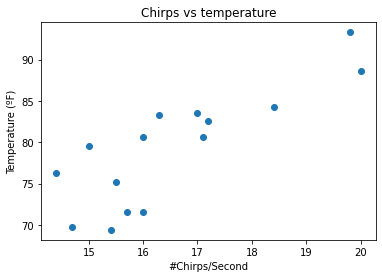

In [229]:
plt.scatter(C,T, label='data')
plt.title('Chirps vs temperature')
plt.xlabel('#Chirps/Second')
plt.ylabel('Temperature (ºF)')

In [230]:
r_chirps = RegresionLineal(alpha = 0.003, max_iters = 10000000, tols = 0)
r_chirps.gradientDescent(C,T)

La función convergió con beta: [22.84870914  3.41033933] en la iteración 383397


In [86]:
#Mediante la siguiente gráfica y un widget intentaré encontrar una recta que minimice el error
def plotGuess(x, y, interceptor, pendiente):
    
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    
    plt.scatter(X,Y, label="data")
    plt.plot(X, modelo(X, interceptor, pendiente), label='Guess')
    plt.xlabel('#Chirps/Second')
    plt.ylabel('Temperature (ºF)')
    plt.legend(loc="best")

In [87]:
interact(plotGuess, x=fixed(C), y=fixed(T), interceptor=(0,2,0.02), pendiente=(0,2, 0.02));

interactive(children=(FloatSlider(value=1.0, description='interceptor', max=2.0, step=0.02), FloatSlider(value…

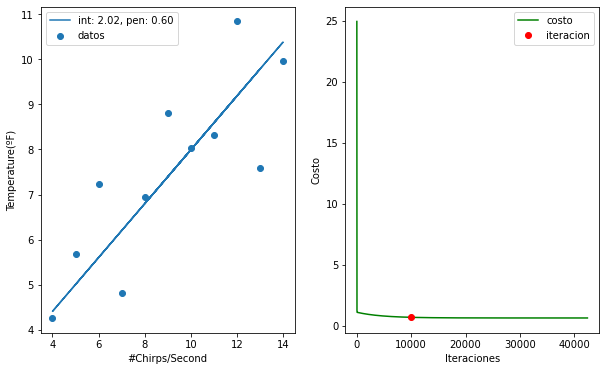

In [162]:
plotModelo(C, T, r_chirps, 10000, '#Chirps/Second', 'Temperature(ºF)')

In [166]:
ult_it_chirps = (r_chirps.breaking_iteration - 1) if r_chirps.breaking_iteration else (r_chirps.max_iters -1)
interact(plotModelo, x = fixed(C), y= fixed(T), rl = fixed(r_chirps), iteracion=(0, ult_it_chirps, 1), ejex = fixed('#Chirps/Second'), ejey = fixed('Temperature(ºF)'));

interactive(children=(IntSlider(value=21205, description='iteracion', max=42410), Output()), _dom_classes=('wi…


**NOTA**: Datos obtenidos de [aquí](http://mathbits.com/MathBits/TISection/Statistics2/linearREAL.htm)


## Problema 4

**(a)** Usando los datos del [cuarteto de Anscombe](http://en.wikipedia.org/wiki/Anscombe%27s_quartet) Calcule la regresión lineal ¿Qué sucede?

In [95]:
anscombe = np.loadtxt('anscombe.txt')
ansc_arr = [[],[],[],[],[],[],[],[]]
for i in anscombe: 
    j = 0
    for k in i: 
        ansc_arr[j].append(k)
        j += 1

A = np.array(ansc_arr)

<Figure size 1600x480 with 0 Axes>

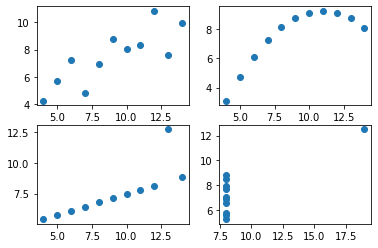

In [99]:
plt.figure(figsize=(20,6), dpi=80)
fig, ax = plt.subplots(2,2)
ax[0,0].scatter(A[0], A[1])
ax[0,1].scatter(A[2], A[3])
ax[1,0].scatter(A[4], A[5])
ax[1,1].scatter(A[6], A[7])

La función convergió con beta: [0.09213854 0.77768274] en la iteración 4724


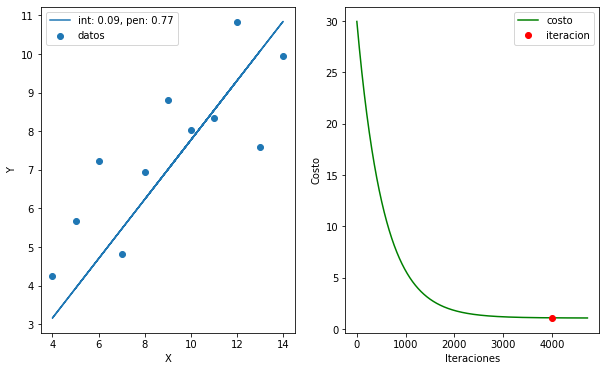

In [168]:
#Gráficas de ax[0,0]
r_subplot1 = RegresionLineal(alpha = 0.00001, max_iters = 10000000, tols = 0.00001)
r_subplot1.gradientDescent(A[0], A[1])
plotModelo(A[0], A[1], r_subplot1, 4000, 'X', 'Y')

La función convergió con beta: [0.09214178 0.77767265] en la iteración 4724


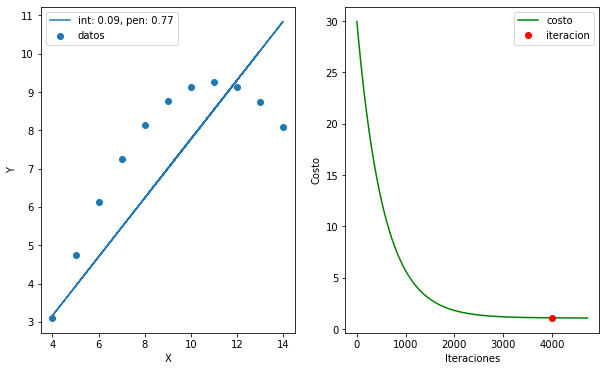

In [170]:
#Gráficas de ax[0,1]
r_subplot2 = RegresionLineal(alpha = 0.00001, max_iters = 10000000, tols = 0.00001)
r_subplot2.gradientDescent(A[2], A[3])
plotModelo(A[2], A[3], r_subplot2, 4000, 'X', 'Y')

La función convergió con beta: [0.09213408 0.77754575] en la iteración 4723


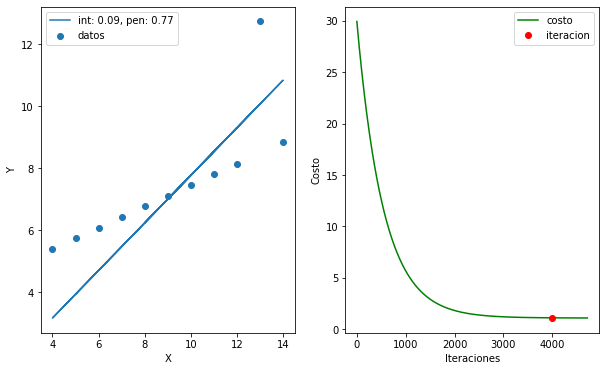

In [171]:
#Gráficas de ax[1,0]
r_subplot3 = RegresionLineal(alpha = 0.00001, max_iters = 10000000, tols = 0.00001)
r_subplot3.gradientDescent(A[4], A[5])
plotModelo(A[4], A[5], r_subplot3, 4000, 'X', 'Y')

La función convergió con beta: [0.09214502 0.77766256] en la iteración 4724


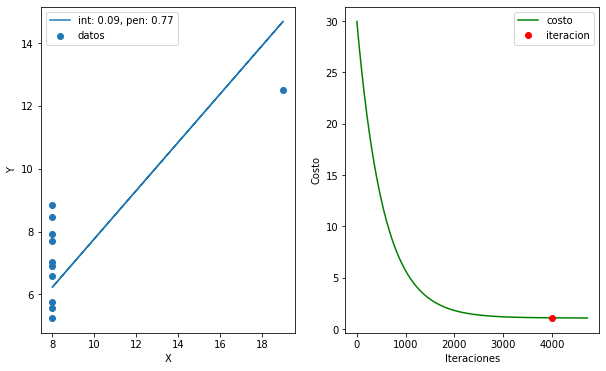

In [172]:
#Gráficas de ax[1,1]
r_subplot4 = RegresionLineal(alpha = 0.00001, max_iters = 10000000, tols = 0.00001)
r_subplot4.gradientDescent(A[6], A[7])
plotModelo(A[6], A[7], r_subplot4, 4000, 'X', 'Y')

## Problema 5

Use el archivo `radioactive_decay.dat`

In [174]:
%cat radioactive_decay.txt

#time   N_(remaining)
0.0	10.48
1.0	7.54
2.0	5.49
3.0	4.02
4.0	2.74
5.0	2.02
6.0	1.50
7.0	1.09
8.0	0.68
9.0	0.57
10.0	0.37
11.0	0.31
12.0	0.19
13.0	0.15
14.0	0.13
15.0	0.11


**(a)** Grafique los datos ¿Qué forma tienen?

In [357]:
archivo = open('radioactive_decay.txt')
time = []
n = []
archivo.readline()
for linea in archivo: 
    l = linea.split('\t')
    time.append(float(l[0]))
    n.append(float(l[1]))
Ti = np.array(time)
N = np.array(n)

Text(0, 0.5, 'N')

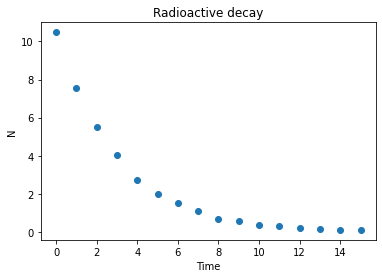

In [358]:
plt.scatter(Ti,N, label = 'data' )
plt.title('Radioactive decay')
plt.xlabel('Time')
plt.ylabel('N')

**(b)** ¿Qué transformación se le ocurre para linearizarlos? Explique y grafique de nuevo. Guarde los datos transformados en un archivo llamado `transform_radioactive_decay.txt`

In [375]:
#Observamos una gráfica parecida a (1/e)^-1, por lo que un logaritmo natural podría ayudarnos a linealizar los datos
N2 = np.zeros(len(Ti))
for i in range(len(Ti)):
    N2[i] = ln(N[i])
#Creamos un arreglo de dos columnas para contener la información 
arr = np.zeros((2, len(Ti)))
arr[0] = Ti
arr[1] = N2
np.savetxt('transform_radioactive_decay.txt', arr)

Text(0, 0.5, 'ln (N)')

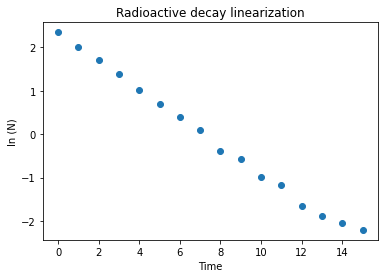

In [376]:
plt.scatter(Ti,N2, label = 'data' )
plt.title('Radioactive decay linearization')
plt.xlabel('Time')
plt.ylabel('ln (N)')

**(c)** Aplique la regresión lineal a este conjunto de datos transformado, leyendo los datos del archivo recién creado.

In [383]:
arr = np.loadtxt('transform_radioactive_decay.txt')
t0 = arr[0]
t1 = arr[1]
r_rd = RegresionLineal(alpha=0.003, max_iters=10000, tols=0.0000001)
r_rd.gradientDescent(t0,t1)
ult_it_rd = (r_rd.breaking_iteration - 1) if r_rd.breaking_iteration else (r_rd.max_iters - 1)
interact(plotModelo, x = fixed(t0), y= fixed(t1), rl = fixed(r_rd), iteracion=(0, ult_it_rd, 1), ejex = fixed('Time'), ejey = fixed('ln (N)'));

La función convergió con beta: [ 2.27548901 -0.31459673] en la iteración 5755


interactive(children=(IntSlider(value=2877, description='iteracion', max=5754), Output()), _dom_classes=('widg…

**(d)** ¿Cuáles son los valores de $\beta$ que mejor ajustan? ¿Cuáles son el espacio sin transformar? Explique.

In [384]:
r_rd.gradientDescent(t0,t1)

La función convergió con beta: [ 2.27548901 -0.31459673] en la iteración 5755


No se transforma el eje de las x (# time), pues se utilizan los mismos valores tanto para la función original como para la linealización, esto se debe a que x es la variable independiente en ambos casos. 